# Optical Selection Validation Plots

Plots:
- Currently, the error on the monte carlo bins is over estimated since it is including the external values and mixing them up, fix this at some point

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [2]:
#df_nue = pd.read_pickle("/home/wouter/Documents/Jupyter/LEE_analyzer/Input/flash_validation_new/nue/nue_0.pckl")

In [3]:
#z_dead_start = 675
#z_dead_end = z_dead_start + 100

#df_nue["true_1eX_signal"].value_counts()
#print(df_nue["vz"].

In [4]:
pd.options.display.max_columns = 999
gr      = 1.618
flux_corr = 1.028

mass_p= 0.93827 #GeV
mass_e= 0.00511 #GeV
# Minimum reconstructable energies:
min_e = 0.02 + mass_e # 20MeV
min_p = 0.04 + mass_p # 40MeV
min_pi = 0.17

outdir = "../../Output/flash_validation/"

In [5]:
def true_thresholds_1e1p(row):
    isProton = False
    isPion = False
    if row["true_1eX_signal"]:
        for pdg,E in zip(*row[["nu_daughters_pdg","nu_daughters_E"]]):
            if pdg==2212 and E>min_p:
                isProton = True
            if pdg in [-211,211,111] and E>min_pi:
                isPion = True
    return isProton and not isPion

#The statistical uncertainity per bin of the binned data.
#If there are weights then the uncertainity will be the root of the
#sum of the weights squared.
def hist_bin_uncertainty(data, weights, bin_edges):
    # Bound the data and weights to be within the bin edges
    in_range_index = [idx for idx in range(len(data)) if data[idx] > min(bin_edges) and data[idx] < max(bin_edges)]
    in_range_data = np.asarray([data[idx] for idx in in_range_index])
    in_range_weights = np.asarray([weights[idx] for idx in in_range_index])

    # Bin the weights with the same binning as the data
    bin_index = np.digitize(in_range_data, bin_edges)
    # N.B.: range(1, bin_edges.size) is used instead of set(bin_index) as if
    # there is a gap in the data such that a bin is skipped no index would appear
    # for it in the set
    binned_weights = np.asarray(
        [in_range_weights[np.where(bin_index == idx)[0]] for idx in range(1, len(bin_edges))])
    bin_uncertainties = np.asarray(
        [np.sqrt(np.sum(np.square(w))) for w in binned_weights])
    return bin_uncertainties

In [6]:
# Options, pick your favorite: 
# name of the file, number of events unweighted, POT, do we need to set the bnbweight?, eventstotal reweighted

nu =          ("nu"         , 197400, 1.99831691626e+20, 0, 194482*flux_corr)
#nu_tune3 =    ("nu_tune3"   , 397600, 4.30525448815e+20, 0, 391551*flux_corr)
#nu_overlaid = ("nu_overlaid", 194756, 2.02719389269e+20, 1, 194756*flux_corr)
#nu_cv =       ("nu_induced" ,  89650, 9.07152583659e+19, 0,  88323*flux_corr)
#nu_lightbug = ("nu_lightbug",  91300, 9.21848616632e+19, 0,  89949*flux_corr)

allnu = [nu]#, nu_tune3, nu_overlaid, nu_cv, nu_lightbug]
which_nu=0

nu_events = allnu[which_nu][4]
nu_pot = allnu[which_nu][2]
df_nu = pd.read_pickle("./input/df_"+allnu[which_nu][0]+"_flash.pckl")
df_nu_candidate = pd.read_pickle("./input/df_"+allnu[which_nu][0]+"_flash_candidate.pckl")
print("nu loaded")


nue_pot = 2.41757769545e+22
df_nue = pd.read_pickle("./input/df_nue_flash.pckl")
df_nue_candidate = pd.read_pickle("./input/df_nue_flash_candidate.pckl")
print("nue loaded")

ext_trig = 14255249
#ext_trig = 22036555
ext_scale = 9779224/ext_trig
df_ext = pd.read_pickle("./input/df_bnbext_a_flash.pckl")
df_ext_candidate = pd.read_pickle("./input/df_bnbext_a_flash_candidate.pckl")
print("ext loaded")

bnb_pot = 4.413e+19
df_bnb = pd.concat([pd.read_pickle("./input/df_bnb_a_flash.pckl"), pd.read_pickle("./input/df_bnb_b_flash.pckl")])
df_bnb_candidate = pd.concat([pd.read_pickle("./input/df_bnb_a_flash_candidate.pckl"), pd.read_pickle("./input/df_bnb_b_flash_candidate.pckl")])
print("bnb loaded")

intime_events = 124643
df_intime = pd.read_pickle("./input/df_intime_flash.pckl")
df_intime_candidate = pd.read_pickle("./input/df_intime_flash_candidate.pckl")
print("intime loaded")

nu loaded
nue loaded
ext loaded
bnb loaded
intime loaded


In [7]:
mc_start = 3.16
bnb_start = 3.19     # mc_start + 2*0.015625 #3.20
ext_start = 3.58     # mc_start + 26*0.015625 #3.58
intime_start = 3.58  # mc_start + 26*0.015625 # 3.58
duration = 1.68

In [8]:
# Parameters to geth the data mc ration in the right spot
ratio_x = 0.70
ratio_y = 8./9
ratio_text = r"$\frac{Beam \ ON}{Beam \ OFF + MC} = $"

In [9]:
#Data
nu_scale = bnb_pot/nu_pot
nue_scale = bnb_pot/nue_pot
intime_scaling = 10.279*(nu_events/intime_events)*(bnb_pot/nu_pot)

df_ext["bnbweight"] = ext_scale
df_ext_candidate["bnbweight"] = ext_scale

df_bnb["bnbweight"] = 1
df_bnb_candidate["bnbweight"] = 1

df_intime["bnbweight"] = intime_scaling
df_intime_candidate["bnbweight"] = intime_scaling

# Those are normally ok, except for overlay, there, set it to 1.028 
if allnu[which_nu][3]==1:
    df_nu["bnbweight"] = flux_corr
    df_nu_candidate["bnbweight"] = flux_corr

In [10]:
nu_flash = np.hstack(df_nu["flash_time"])
bnb_flash = np.hstack(df_bnb["flash_time"])
ext_flash = np.hstack(df_ext["flash_time"])
nu_flash_weight = np.hstack(df_nu["bnbweight"])
intime_flash = np.hstack(df_intime["flash_time"])

199927.496


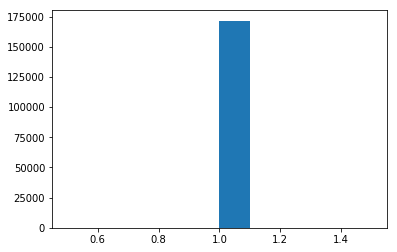

In [11]:
len(df_intime.query("flash_PE_max>1")["flash_PE_max"])
plt.hist(df_bnb["bnbweight"])
print(allnu[which_nu][4])

50


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars


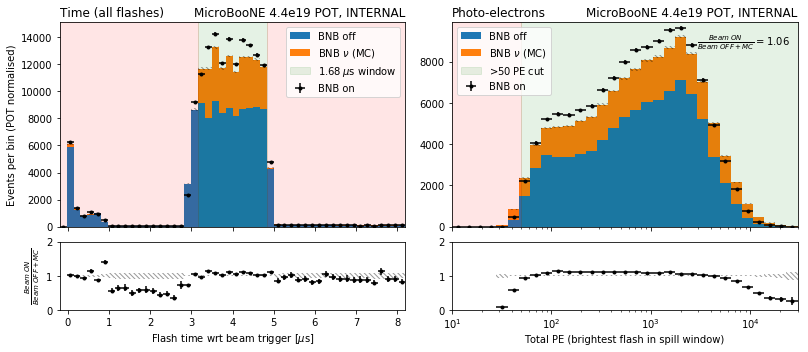

In [12]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5),sharex='col', gridspec_kw = {'height_ratios':[3, 1]})

y_r_min=0
y_r_max=2

ext_weights = np.array([ext_scale]*len(ext_flash))
nu_weights = np.array([nu_scale]*len(nu_flash))*flux_corr*0.985 # 0.985 is the average weight 

#Left plot
x_min = -0.2
x_max = 8.2
N= round((x_max-x_min)/0.168)
print(N)
bhalf = (x_max-x_min)/(2*N)

#if we are using overlaid instead of MC, we use # -(ext_start-mc_start)
bins,edges = np.histogram(bnb_flash-(bnb_start-mc_start),bins=N,range=(x_min,x_max))
ax[0][0].errorbar(edges[:-1]+bhalf, bins, xerr=bhalf, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax[0][0].hist(ext_flash-(ext_start-mc_start),alpha=1.0,bins=N, range = (x_min, x_max), weights = ext_weights, label = "BNB off" )
mc_bins,_,_ = ax[0][0].hist(nu_flash,alpha=1.0,bins=N, range = (x_min, x_max), weights = nu_weights, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower 

ax[0][0].axvspan(x_min,mc_start, alpha=0.1, color="red")
ax[0][0].axvspan(mc_start,mc_start+duration, alpha=0.1, color="green",label=str(duration)+"$\: \mu$s window" )
ax[0][0].axvspan(mc_start+duration,x_max, alpha=0.1, color="red")

ax[0][0].set_title(r"Time (all flashes)", loc='left')
ax[0][0].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')

ax[1][0].set_xlabel(r"Flash time wrt beam trigger [$\mu$s]")
ax[0][0].set_ylabel(r"Events per bin (POT normalised)")
ax[0][0].legend(loc="upper right")
ax[0][0].set_xlim(x_min,x_max)

# Ratio plot left
mc_ext_err = np.sqrt(  (np.sqrt(mc_bins/nu_scale)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)
for this_err,entry,bin_start in zip(mc_ext_err,mc_bins,edges[:-1]):
    ax[0][0].add_patch(patches.Rectangle( (bin_start, entry-this_err), bhalf*2, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][0].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bhalf*2, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
ax[1][0].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][0].errorbar(edges[:-1]+bhalf, bins/mc_bins, xerr=bhalf, yerr=np.sqrt(bins)/mc_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")
ax[1][0].set_ylim(y_r_min,y_r_max)


# Right plot
x_min = 10
x_max = 30000
N=32
bhalf = (x_max-x_min)/(2*N)
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
x_err= [(edges[i+1]-edges[i])/2 for i in range(N-1)]
y_max = 9900

edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]
                         
bins,_ = np.histogram(df_bnb.query("flash_PE_max>1")["flash_PE_max"],bins=edges)
ax[0][1].errorbar(edges_mid, bins, xerr=x_err, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax[0][1].hist(df_ext["flash_PE_max"],alpha=1.0,bins=edges, weights = df_ext["bnbweight"], label = "BNB off" )
mc_bins,_,_ = ax[0][1].hist(df_nu["flash_PE_max"],alpha=1.0,bins=edges, weights = df_nu["bnbweight"]*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower
ax[0][1].set_title(r"Photo-electrons", loc='left')
ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')


ax[1][1].set_xlabel(r"Total PE (brightest flash in spill window)")
ax[0][1].set_xlim(x_min,x_max)
ax[0][1].set_ylim(0,y_max)
ax[0][1].axvspan(x_min,50, alpha=0.1, color="red")
ax[0][1].axvspan(50,x_max, alpha=0.1, color="green",label=">$50 \:$PE cut" )
ax[0][1].legend(loc="upper left")
ax[0][1].set_xscale("log", nonposx='clip')

ax[1][1].errorbar(edges_mid, bins/mc_bins, xerr=x_err, yerr=np.sqrt(bins)/mc_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")
ax[1][1].set_ylim(y_r_min,y_r_max)

ratio = df_bnb.query("flash_PE_max>1")["bnbweight"].sum() / ( df_ext.query("flash_PE_max>1")["bnbweight"].sum() + df_nu.query("flash_PE_max>1")["bnbweight"].sum()*nu_scale )
ax[0][1].text(edges[round(N*ratio_x)],ratio_y*y_max,ratio_text+'{0:.2f}'.format(ratio))

# Ratio plots
mc_err_weighted = hist_bin_uncertainty(df_nu.query("flash_PE_max>1")["flash_PE_max"].tolist(), 
                                       df_nu.query("flash_PE_max>1")["bnbweight"].tolist(), edges)

mc_ext_err = np.sqrt(  (np.array(mc_err_weighted)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)

for this_err,entry,bin_start,bin_end in zip(mc_ext_err,mc_bins,edges[:-1],edges[1:]):
    ax[0][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bin_end-bin_start, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

fig.tight_layout(h_pad=0.5)
plt.savefig( outdir+"time_pe_ratio.pdf")

In [13]:
df_flash_late = df_nue.query("true_1eX_signal==1")[["flash_time","true_vz"]]
true_z=[]
flash_time_first=[]
flash_time_last=[]
num_flash=[]

for index, row in df_flash_late.iterrows():
    if np.any(np.logical_and(np.array(4.8 > row["flash_time"]), np.array(row["flash_time"]>3.2))) :
        true_z.append(row["true_vz"])
        flash_time_first.append(min(row["flash_time"]))
        flash_time_last.append(max(row["flash_time"]))
        num_flash.append(len(row["flash_time"]))

In [14]:
#print(len(true_z))
#print(len(df_flash_late))
#print(len(true_z)/len(df_flash_late)*100)

print(sum(df_nue_candidate.query("(true_1eX_signal==1) & (number_primary_tracks==track_passed) \
                       & (number_primary_showers==shower_passed) & (true_z_deadwire==1) & flash_passed>-3")["bnbweight"]))
print(sum(df_nue_candidate.query("(true_1eX_signal==1) & (number_primary_tracks==track_passed) \
                       & (number_primary_showers==shower_passed) & (true_z_deadwire==1) & (chargecenter_candidates_total>1) & flash_passed>-1")["bnbweight"]))

25002.369168986144
20685.12543388312


In [15]:
starttimes = np.arange(3.0,3.5,0.005)

x_min = 1
x_max = 8
N=7*4
ext_offset = 24.5*0.015625 # bnb vs extbnb offset in micros
residuals = []

print(len(nu_flash_weight))
print(len(nu_flash))

for start_time in starttimes:
    #print("BNB start:", start_time)
    bnb_offset = start_time-(3.16)
    data_beam_on,_ = np.histogram(bnb_flash-bnb_offset,bins=N,range=(x_min,x_max))
    data_beam_off,_ = np.histogram(ext_flash-bnb_offset-ext_offset,bins=N,range=(x_min,x_max), weights = [ext_scale]*len(ext_flash))
    mc_nu,_ = np.histogram(nu_flash,bins=N,range=(x_min,x_max), weights=np.array([nu_scale]*len(nu_flash))*flux_corr)
    
    res = sum((data_beam_on-data_beam_off-mc_nu)**2)
    residuals.append(res)

197400
188018


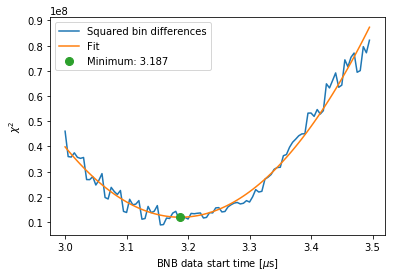

In [16]:
import numpy.polynomial.polynomial as poly

plt.plot(starttimes,residuals,label="Squared bin differences")
coefs= poly.polyfit(starttimes, residuals, 2)
ffit = poly.polyval(starttimes, coefs)
plt.plot(starttimes, ffit, label="Fit")
minimum = -coefs[1]/(2*coefs[2])
plt.plot(minimum, poly.polyval(minimum, coefs), label="Minimum: "+'{0:.3f}'.format(minimum),marker='o', markersize=8,lw=0)
plt.legend()
plt.xlabel(r"BNB data start time [$\mu$s]")
plt.ylabel(r"$\chi^2$")
plt.savefig( outdir+"time_fit.pdf")

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


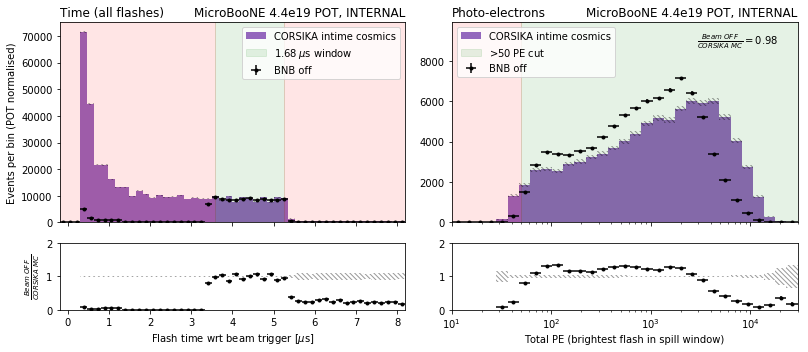

In [17]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5),sharex='col', gridspec_kw = {'height_ratios':[3, 1]})

y_r_min=0
y_r_max=2

ext_weights = np.array([ext_scale]*len(ext_flash))
corsika_weights = np.array([intime_scaling]*len(intime_flash))

x_min = -0.2
x_max = 8.2
N= round((x_max-x_min)/0.168)
bhalf = (x_max-x_min)/(2*N)
bhalf = (x_max-x_min)/(2*N)

bins,edges = np.histogram(ext_flash,bins=N,range=(x_min,x_max))
ax[0][0].errorbar(edges[:-1]+bhalf, bins*ext_scale, xerr=bhalf, yerr=np.sqrt(bins)*ext_scale,alpha=1.0, color= "k",fmt=".",label="BNB off")
corsika_bins,_,_ = ax[0][0].hist(intime_flash,alpha=1.0,bins=N, color="C4", range = (x_min, x_max), weights = corsika_weights, label=r"CORSIKA intime cosmics")

ax[0][0].axvspan(x_min,ext_start, alpha=0.1, color="red")
ax[0][0].axvspan(ext_start,ext_start+duration, alpha=0.1, color="green",label=str(duration)+"$\: \mu$s window" )
ax[0][0].axvspan(ext_start+duration,x_max, alpha=0.1, color="red")

ax[0][0].set_title(r"Time (all flashes)", loc='left')
ax[0][0].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')

ax[1][0].set_xlabel(r"Flash time wrt beam trigger [$\mu$s]")
ax[0][0].set_ylabel(r"Events per bin (POT normalised)")
ax[0][0].legend(loc="upper right")
ax[0][0].set_xlim(x_min,x_max)

# Ratio plot left
corsika_err = (np.sqrt(corsika_bins/intime_scaling)*intime_scaling)
for this_err,entry,bin_start in zip(corsika_err,corsika_bins,edges[:-1]):
    ax[0][0].add_patch(patches.Rectangle( (bin_start, entry-this_err), bhalf*2, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][0].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bhalf*2, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
ax[1][0].set_ylabel(r'$\frac{Beam\ OFF}{CORSIKA\ MC}$')
ax[1][0].errorbar(edges[:-1]+bhalf, bins*ext_scale/corsika_bins, xerr=bhalf, yerr=np.sqrt(bins)*ext_scale/corsika_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")
ax[1][0].set_ylim(y_r_min,y_r_max)

x_min = 10
x_max = 30000
N=32
bhalf = (x_max-x_min)/(2*N)
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
x_err= [(edges[i+1]-edges[i])/2 for i in range(N-1)]
y_max = 9900

edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]
                         
bins,_ = np.histogram(df_ext["flash_PE_max"],bins=edges)
ax[0][1].errorbar(edges_mid, bins*ext_scale, xerr=x_err, yerr=np.sqrt(bins)*ext_scale,alpha=1.0, color= "k",fmt=".",label="BNB off")
corsika_bins,_,_ = ax[0][1].hist(df_intime["flash_PE_max"],alpha=1.0,bins=edges, color="C4", weights = [intime_scaling]*len(df_intime["flash_PE_max"]), label=r"CORSIKA intime cosmics")
ax[0][1].set_title(r"Photo-electrons", loc='left')
ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')
ax[1][1].set_xlabel(r"Total PE (brightest flash in spill window)")
ax[0][1].set_xlim(x_min,x_max)
ax[0][1].axvspan(x_min,50, alpha=0.1, color="red")
ax[0][1].axvspan(50,x_max, alpha=0.1, color="green",label=">$50 \:$PE cut" )
ax[0][1].legend(loc="upper left")
ax[0][1].set_xscale("log", nonposx='clip')
ax[0][1].set_ylim(0,y_max)
ratio = df_ext.query("flash_PE_max>1")["bnbweight"].sum()/  df_intime.query("flash_PE_max>1")["bnbweight"].sum()

# Ratio plot left
corsika_err = (np.sqrt(corsika_bins/intime_scaling)*intime_scaling)
for this_err,entry,bin_start,bin_end in zip(corsika_err,corsika_bins,edges[:-1],edges[1:]):
    ax[0][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bin_end-bin_start, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
ax[1][1].errorbar(edges_mid, bins*ext_scale/corsika_bins, xerr=x_err, yerr=np.sqrt(bins)*ext_scale/corsika_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")
ax[1][1].set_ylim(y_r_min,y_r_max)

ax[0][1].text(edges[round(N*ratio_x)],ratio_y*y_max,r"$\frac{Beam\ OFF}{CORSIKA\ MC} = $"+'{0:.2f}'.format(ratio))

fig.tight_layout()
plt.savefig( outdir+"time_pe_ext.pdf")

#fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(5*gr,3),sharex=True,sharey=False)

plt.figure(figsize=(6*gr,6))
ax=np.empty(5)
ax0 = plt.subplot2grid((4, 3), (1, 0), rowspan=2)
ax1 = plt.subplot2grid((4, 3), (0, 1), rowspan=2)
ax2 = plt.subplot2grid((4, 3), (0, 2), rowspan=2)
ax3 = plt.subplot2grid((4, 3), (2, 1), rowspan=2)
ax4 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)

N=11
x_min = -0.5
x_max = x_min+N
x_ticks=range(N) 

str_signal = "true_1eX_signal==1"
str_after = "flash_PE_max>50"
str_signal_after = "true_1eX_signal==1 & flash_PE_max>50"

ax0.hist(df_nue.query(str_signal)["n_primaries"],alpha=0.5,bins=N, range = (x_min, x_max), rwidth=0.75, label = "All events", weights= df_nue.query(str_signal)["bnbweight"]*nue_scale, color = "k"  )
ax0.hist(df_nue.query(str_signal_after)["n_primaries"],alpha=0.7,bins=N, color="C2", range = (x_min, x_max), rwidth=0.75, label = "With valid flash" , weights = df_nue.query(str_signal_after)["bnbweight"]*nue_scale )
ax0.set_xticks(x_ticks)
ax0.set_title(r"MC signal ($\nu_e$ 1eX)")
ax0.set_xlabel(r"# $\nu$ candidates")
ax0.set_ylabel(r"# Events per bin")
ax0.set_ylim(0,24)
ax0.legend()

#Data
bins,edges = np.histogram(df_bnb["n_primaries"],bins=N,range=(x_min,x_max))
ax1.errorbar(edges[:-1]+0.5, bins, xerr=0.5*0.75, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on (4.4e19 POT)")
lower,_,_ = ax1.hist(df_ext["n_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = df_ext["bnbweight"], label = "BNB off" )
ax1.hist(df_nu["n_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = df_nu["bnbweight"]*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
ax1.set_title(r"BNB on (All events)")
ax1.set_xlabel(r"# $\nu$ candidates")
ax1.set_ylim(0,78000)
ax1.set_xticks(x_ticks)
print("bnb event with flash and 0 candidates:",bins)
print("MC event with flash and 0 candidates:",sum(df_nu.query("flash_PE_max>50 & n_primaries==0")["bnbweight"]))

bins,edges = np.histogram(df_bnb.query(str_after)["n_primaries"],bins=N,range=(x_min,x_max))
ax2.errorbar(edges[:-1]+0.5, bins, xerr=0.5*0.75, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on (4.4e19 POT)")
lower,_,_ = ax2.hist(df_ext.query(str_after)["n_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = df_ext.query(str_after)["bnbweight"], label = "BNB off" )
ax2.hist(df_nu.query(str_after)["n_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = df_nu.query(str_after)["bnbweight"]*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
ax2.set_title(r"BNB on (With valid flash)")
ax2.set_xlabel(r"# $\nu$ candidates")
ax2.set_xticks(x_ticks)
ax2.legend(loc="upper center")
ax2.set_ylim(0,78000)

bins,edges = np.histogram(df_ext["n_primaries"],weights=df_ext["bnbweight"] ,bins=N,range=(x_min,x_max))
ax3.errorbar(edges[:-1]+0.5, bins, xerr=0.5*0.75, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB off")
ax3.hist(df_intime["n_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), color="C4", rwidth=0.75, weights = df_intime["bnbweight"], label=r"CORSIKA Cosmic intime")
ax3.set_title(r"BNB off (All events)")
ax3.set_xlabel(r"# $\nu$ candidates")
ax3.set_xticks(x_ticks)
ax3.set_ylim(0,78000)
print("bnb off event with flash and 0 candidates:",bins)

bins,edges = np.histogram(df_ext.query(str_after)["n_primaries"],weights=df_ext.query(str_after)["bnbweight"] ,bins=N,range=(x_min,x_max))
ax4.errorbar(edges[:-1]+0.5, bins, xerr=0.5*0.75, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB off")
ax4.hist(df_intime.query(str_after)["n_primaries"],alpha=1.0,bins=N, color="C4", range = (x_min, x_max), rwidth=0.75, weights = df_intime.query(str_after)["bnbweight"], label=r"Cosmic intime")
ax4.set_title(r"BNB off (With valid flash)")
ax4.set_xticks(x_ticks)
ax4.legend(loc="upper center")
ax4.set_xlabel(r"# $\nu$ candidates")
ax4.set_ylim(0,78000)

plt.figtext(0.05,.95,r"MicroBooNE 4.4e19 POT, INTERNAL")

plt.tight_layout()
plt.savefig( outdir+"n_candidates_flash.pdf")

In [18]:
str_signal = "n_primaries==0 & flash_PE_max>50"
#str_after = "flash_PE_max>50"
#str_signal_after = "true_1eX_signal==1 & flash_PE_max>50"
len(df_nu.query(str_signal)["n_primaries"])

2981

#fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(5*gr,3),sharex=True,sharey=False)

plt.figure(figsize=(6*gr,6))
ax=np.empty(5)
ax0 = plt.subplot2grid((4, 3), (1, 0), rowspan=2)
ax1 = plt.subplot2grid((4, 3), (0, 1), rowspan=2)
ax2 = plt.subplot2grid((4, 3), (0, 2), rowspan=2)
ax3 = plt.subplot2grid((4, 3), (2, 1), rowspan=2)
ax4 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)

N=8
x_min = -0.5
x_max = x_min+N
x_ticks=range(N) 

str_query = "flash_PE_max>50"
str_query_signal = "true_1eX_signal==1 & flash_PE_max>50"

ax0.hist(df_nue.query(str_query_signal)["n_primaries"],alpha=0.5,bins=N, range = (x_min, x_max), rwidth=0.75, label = "Before cuts", weights= df_nue.query(str_query_signal)["bnbweight"]*nue_scale, color = "k"  )
ax0.hist(df_nue.query(str_query_signal)["passed_primaries"],alpha=0.7,bins=N, color="C2", range = (x_min, x_max), rwidth=0.75, label = "After cuts" , weights = df_nue.query(str_query_signal)["bnbweight"]*nue_scale )
ax0.set_xticks(x_ticks)
ax0.set_title(r"MC signal ($\nu_e$ 1eX)")
ax0.set_xlabel(r"# $\nu$ candidates")
ax0.set_ylabel(r"# Events per bin")
ax0.legend()

#Data
bins,edges = np.histogram(df_bnb.query(str_query)["n_primaries"],bins=N,range=(x_min,x_max))
ax1.errorbar(edges[:-1]+0.5, bins, xerr=0.5*0.75, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax1.hist(df_ext.query(str_query)["n_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = df_ext.query(str_query)["bnbweight"], label = "BNB off" )
ax1.hist(df_nu.query(str_query)["n_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = df_nu.query(str_query)["bnbweight"]*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
ax1.set_title(r"BNB on (Before cuts)")
ax1.set_xlabel(r"# $\nu$ candidates")
ax1.legend(loc="upper center")
ax1.set_ylim(0,78000)
ax1.set_xticks(x_ticks)
print("bnb event with flash and 0 candidates:",bins)
print("MC event with flash and 0 candidates:",sum(df_nu.query("flash_PE_max>50 & n_primaries==0")["bnbweight"]))

bins,edges = np.histogram(df_bnb.query(str_query)["passed_primaries"],bins=N,range=(x_min,x_max))
ax2.errorbar(edges[:-1]+0.5, bins, xerr=0.5*0.75, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax2.hist(df_ext.query(str_query)["passed_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = df_ext.query(str_query)["bnbweight"], label = "BNB off" )
ax2.hist(df_nu.query(str_query)["passed_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = df_nu.query(str_query)["bnbweight"]*nu_scale, label=r"BNB $\nu_\mu (MC)$",  bottom = lower )
ax2.set_title(r"BNB on (After cuts)")
ax2.set_xlabel(r"# $\nu$ candidates")
ax2.set_xticks(x_ticks)
ax2.set_ylim(0,78000)

bins,edges = np.histogram(df_ext.query(str_query)["n_primaries"],weights=df_ext.query(str_query)["bnbweight"] ,bins=N,range=(x_min,x_max))
ax3.errorbar(edges[:-1]+0.5, bins, xerr=0.5*0.75, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB off")
ax3.hist(df_intime.query(str_query)["n_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), color="C4", rwidth=0.75, weights = df_intime.query(str_query)["bnbweight"], label=r"CORSIKA Cosmic intime")
ax3.set_title(r"BNB off (Before cuts)")
ax3.set_xlabel(r"# $\nu$ candidates")
ax3.legend(loc="upper center")
ax3.set_xticks(x_ticks)
ax3.set_ylim(0,78000)
print("bnb off event with flash and 0 candidates:",bins)

bins,edges = np.histogram(df_ext.query(str_query)["passed_primaries"],weights=df_ext.query(str_query)["bnbweight"] ,bins=N,range=(x_min,x_max))
ax4.errorbar(edges[:-1]+0.5, bins, xerr=0.5*0.75, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB off")
ax4.hist(df_intime.query(str_query)["passed_primaries"],alpha=1.0,bins=N, color="C4", range = (x_min, x_max), rwidth=0.75, weights = df_intime.query(str_query)["bnbweight"], label=r"Cosmic intime")
ax4.set_title(r"BNB off (After cuts)")
ax4.set_xticks(x_ticks)
ax4.set_xlabel(r"# $\nu$ candidates")
ax4.set_ylim(0,78000)

plt.figtext(0.05,.95,r"MicroBooNE 4.4e19 POT, INTERNAL")

plt.tight_layout()
plt.savefig( outdir+"n_candidates.pdf")

bnb event with flash and 0 candidates: [ 6568 45294 34863 23111 11193  4574  1510   473]
MC event with flash and 0 candidates: 3018.528617623965


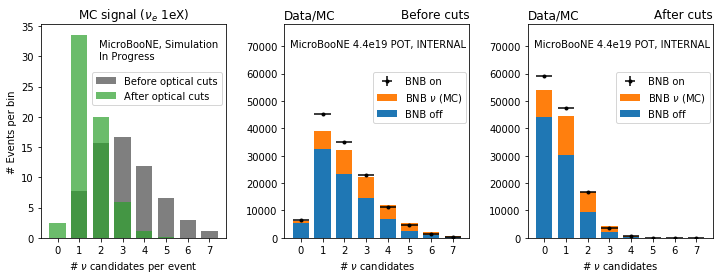

In [29]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=((6.3*gr,4)),sharex=True,sharey=False)

ax0 = ax[0]
ax1 = ax[1]
ax2 = ax[2]

N=8
x_min = -0.5
x_max = x_min+N
x_ticks=range(N) 

str_query = "flash_PE_max>50"
str_query_signal = "true_1eX_signal==1 & flash_PE_max>50"

ax0.hist(df_nue.query(str_query_signal)["n_primaries"],alpha=0.5,bins=N, range = (x_min, x_max), rwidth=0.75, label = "Before optical cuts", weights= df_nue.query(str_query_signal)["bnbweight"]*nue_scale, color = "k"  )
ax0.hist(df_nue.query(str_query_signal)["passed_primaries"],alpha=0.7,bins=N, color="C2", range = (x_min, x_max), rwidth=0.75, label = "After optical cuts" , weights = df_nue.query(str_query_signal)["bnbweight"]*nue_scale )
ax0.set_xticks(x_ticks)
ax0.set_title(r"MC signal ($\nu_e$ 1eX)")
ax0.set_xlabel(r"# $\nu$ candidates per event")
ax0.set_ylabel(r"# Events per bin")
ax0.legend(bbox_to_anchor=[0.25, 0.6])

#Data
bins,edges = np.histogram(df_bnb.query(str_query)["n_primaries"],bins=N,range=(x_min,x_max))
ax1.errorbar(edges[:-1]+0.5, bins, xerr=0.5*0.75, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax1.hist(df_ext.query(str_query)["n_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = df_ext.query(str_query)["bnbweight"], label = "BNB off" )
ax1.hist(df_nu.query(str_query)["n_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = df_nu.query(str_query)["bnbweight"]*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
ax1.set_title(r"Data/MC", loc='left')
ax1.set_title(r"Before cuts", loc='right')
ax1.set_xlabel(r"# $\nu$ candidates")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],bbox_to_anchor=[0.45, 0.8])
ax2.legend(handles[::-1], labels[::-1],bbox_to_anchor=[0.45, 0.8])
ax1.set_ylim(0,78000)
ax1.set_xticks(x_ticks)
print("bnb event with flash and 0 candidates:",bins)
print("MC event with flash and 0 candidates:",sum(df_nu.query("flash_PE_max>50 & n_primaries==0")["bnbweight"]))


bins,edges = np.histogram(df_bnb.query(str_query)["passed_primaries"],bins=N,range=(x_min,x_max))
ax2.errorbar(edges[:-1]+0.5, bins, xerr=0.5*0.75, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax2.hist(df_ext.query(str_query)["passed_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = [ext_scale]*len(df_ext.query(str_query)["bnbweight"]), label = "BNB off" )
ax2.hist(df_nu.query(str_query)["passed_primaries"],alpha=1.0,bins=N, range = (x_min, x_max), rwidth=0.75, weights = df_nu.query(str_query)["bnbweight"]*nu_scale, label=r"BNB $\nu_\mu (MC)$",  bottom = lower )
ax2.set_title(r"Data/MC", loc='left')
ax2.set_title(r"After cuts", loc='right')
ax2.set_xlabel(r"# $\nu$ candidates")
ax2.set_xticks(x_ticks)
ax2.set_ylim(0,78000)

plt.figtext(0.14,0.78, "MicroBooNE, Simulation\nIn Progress")
plt.figtext(0.4,0.82, "MicroBooNE 4.4e19 POT, INTERNAL")
plt.figtext(0.732,0.82, "MicroBooNE 4.4e19 POT, INTERNAL")

plt.tight_layout()
plt.savefig( outdir+"n_candidates.pdf")

In [20]:
str_query = "flash_PE_max>50"
print(df_bnb.query(str_query)["n_primaries"].sum())
print(len(df_bnb_candidate.query(str_query)))

print(df_ext.query(str_query)["n_primaries"].sum()*ext_scale)
print(len(df_ext_candidate.query(str_query))*ext_scale)

print( sum( df_nu.query(str_query)["n_primaries"]*df_nu.query(str_query)["bnbweight"]) *nu_scale )
print(df_nu_candidate.query(str_query)["bnbweight"].sum()*nu_scale)

print(265751/(170052.6241027428+95472.59290910575))


print(df_bnb.query(str_query)["n_primaries"].value_counts())

265751
265751
170052.6241027428
170052.6241027428
95472.59290910575
95472.59290912717
1.0008503259716437
1     45294
2     34863
3     23111
4     11193
0      6568
5      4574
6      1510
7       473
8       113
9        27
10       14
11        3
14        2
12        2
13        1
Name: n_primaries, dtype: int64


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


265751
265751
265751
265751


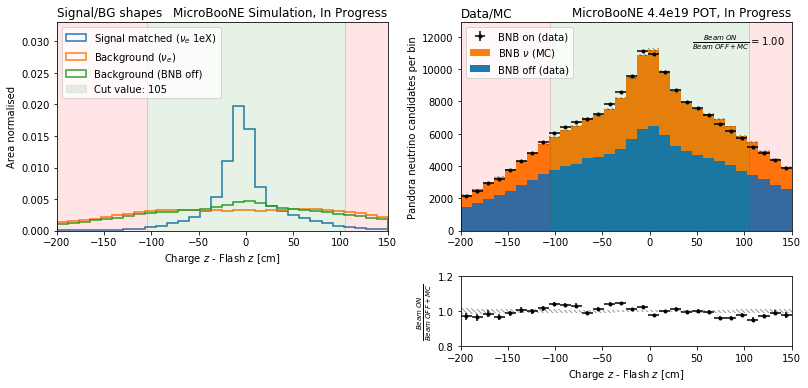

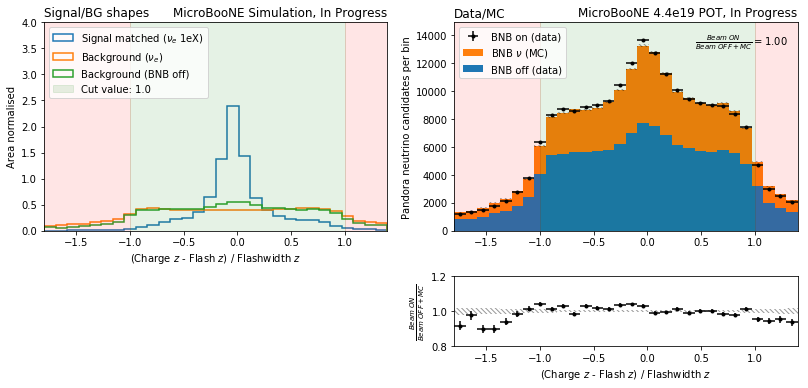

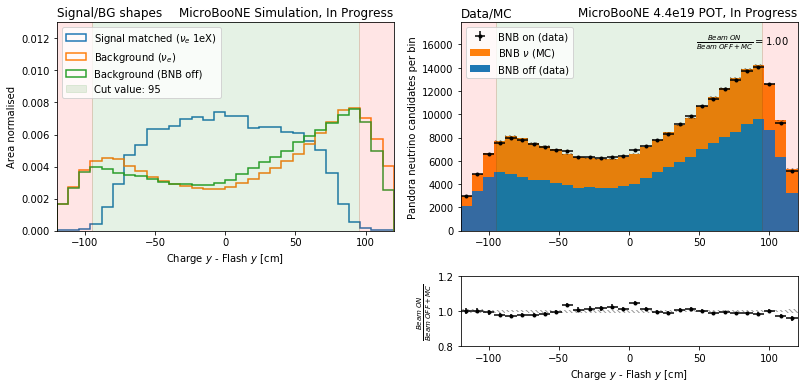

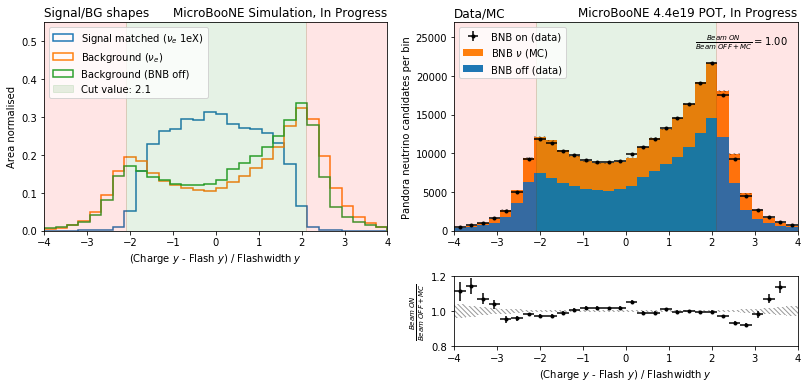

In [31]:
x_axis_arr = ["diff_z", "diff_sz", "diff_y", "diff_sy"]
x_label_arr = [r"Charge $z$ - Flash $z$ [cm]", "(Charge $z$ - Flash $z$) / Flashwidth $z$",
               r"Charge $y$ - Flash $y$ [cm]", "(Charge $y$ - Flash $y$) / Flashwidth $y$"]

x_min_arr =  [-200,-1.8,-120,-4.0]
x_max_arr =  [150,1.4,120,4.0]
bins_arr = [30,30,30,30]
y_max_arr = [0.033,4.0,0.013,0.55]
y_max_2_arr = [12900,14900,17900,26900]
cut_arr = [105,1.0,95,2.1]

y_r_min=0.8
y_r_max=1.2

for x_axis, x_label, x_min, x_max, bins, y_max, y_max2, cut in zip(x_axis_arr, x_label_arr, x_min_arr, x_max_arr, bins_arr, y_max_arr, y_max_2_arr ,cut_arr):
    
    fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5.5), gridspec_kw = {'height_ratios':[3, 1]})

    ax[0][0].hist(df_nue_candidate.query("good==1")[x_axis], range=(x_min,x_max),bins=bins,histtype="step", 
               stacked=False, fill=False, weights=df_nue_candidate.query("good==1")["bnbweight"], label = r"Signal matched ($\nu_e$ 1eX)", density = 1,lw=1.5)
    ax[0][0].hist(df_nue_candidate.query("bad==1")[x_axis] , range=(x_min,x_max),bins=bins,histtype="step", 
               stacked=False, fill=False, weights=df_nue_candidate.query("bad==1")["bnbweight"], label = r"Background ($\nu_e$)", density = 1,lw=1.5)
    
    ax[0][0].hist(df_ext_candidate.query("bad==1")[x_axis] , range=(x_min,x_max),bins=bins,histtype="step", 
               stacked=False, fill=False, weights=df_ext_candidate.query("bad==1")["bnbweight"], label = r"Background (BNB off)", density = 1,lw=1.5)
    
    ax[0][0].axvspan(x_min,-cut, alpha=0.1, color="red")
    ax[0][0].axvspan(-cut,cut, alpha=0.1, color="green",label="Cut value: "+str(cut) )
    ax[0][0].axvspan(cut,x_max, alpha=0.1, color="red")
    ax[0][0].set_title(r"Signal/BG shapes", loc='left')
    ax[0][0].set_title(r"MicroBooNE Simulation, In Progress", loc='right')
    ax[0][0].legend(loc="upper left")
    ax[0][0].set_xlabel(x_label)
    ax[0][0].set_ylabel("Area normalised")
    ax[0][0].set_ylim(0,y_max)
    ax[0][0].set_xlim(x_min,x_max)
    fig.delaxes(ax[1][0])
    
    str_query = "flash_passed>-3"
    bhalf = (x_max-x_min)/(2*bins)
    
    values,edges = np.histogram(df_bnb_candidate.query(str_query)[x_axis],bins=bins,range=(x_min,x_max))
    ax[0][1].errorbar(edges[:-1]+bhalf, values, xerr=bhalf, yerr=np.sqrt(bins), color= "k",fmt=".",label="BNB on (data)")
    lower,_,_ = ax[0][1].hist(df_ext_candidate.query(str_query)[x_axis],bins=bins, range = (x_min, x_max), weights = df_ext_candidate.query(str_query)["bnbweight"], label = "BNB off (data)" )
    
    mc_bins,_,_ = ax[0][1].hist(df_nu_candidate.query(str_query)[x_axis],alpha=1.0,bins=bins, range = (x_min, x_max), weights = df_nu_candidate.query(str_query)["bnbweight"]*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
    mc_bins+=lower
    ax[0][1].set_title(r"Data/MC", loc='left')
    ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, In Progress", loc='right')
    ax[1][1].set_xlabel(x_label)
    handles, labels = ax[0][1].get_legend_handles_labels()
    ax[0][1].legend(handles[::-1], labels[::-1],loc="upper left")
    
    ax[0][1].set_ylabel("Pandora neutrino candidates per bin")
    ax[0][1].axvspan(x_min,-cut, alpha=0.1, color="red")
    ax[0][1].axvspan(-cut,cut, alpha=0.1, color="green")
    ax[0][1].axvspan(cut,x_max, alpha=0.1, color="red")
    
    ax[0][1].set_ylim(0,y_max2)
    ax[0][1].set_xlim(x_min,x_max)
    ratio = len(df_bnb_candidate.query(str_query)) / ( df_ext_candidate.query(str_query)["bnbweight"].sum() + df_nu_candidate.query(str_query)["bnbweight"].sum()*nu_scale )
    ax[0][1].text(edges[round(bins*ratio_x)],ratio_y*y_max2,ratio_text+'{0:.2f}'.format(ratio))

    # Ratio plots
    ax[1][1].set_ylim(y_r_min,y_r_max)
    ax[1][1].set_xlim(x_min,x_max)
    ax[1][1].errorbar(edges[:-1]+bhalf, values/mc_bins, xerr=bhalf, yerr=np.sqrt(values)/mc_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")

    mc_err_weighted = hist_bin_uncertainty(df_nu_candidate.query(str_query)[x_axis].tolist(), 
                                        df_nu_candidate.query(str_query)["bnbweight"].tolist(), edges)

    mc_ext_err = np.sqrt(  (np.array(mc_err_weighted)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)

    for this_err,entry,bin_start,bin_end in zip(mc_ext_err,mc_bins,edges[:-1],edges[1:]):
        ax[0][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
        sc_err = this_err/entry
        ax[1][1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bin_end-bin_start, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')

    print(len(df_bnb_candidate.query(str_query)[x_axis]))
    fig.tight_layout()
    fig.savefig( outdir+x_axis+".pdf")

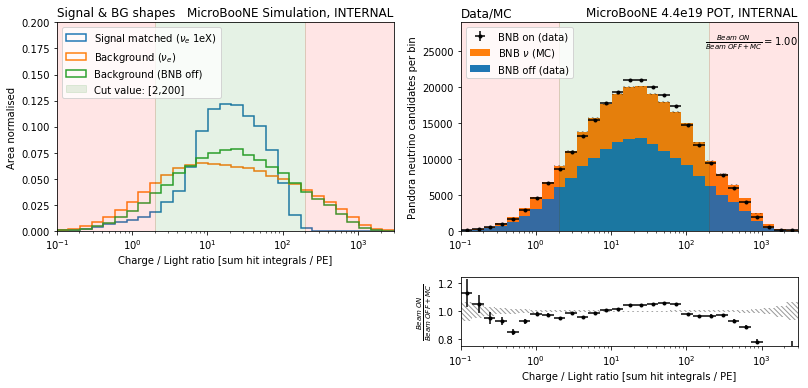

In [22]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5.5), gridspec_kw = {'height_ratios':[3, 1]})
y_r_min=0.75
y_r_max=1.25

x_min = 0.1
x_max = 3000
N=30
bhalf = (x_max-x_min)/(2*N)
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
cut = 3.0
y_max = 0.20

x_err= [(edges[i+1]-edges[i])/2 for i in range(N-1)]
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]

ax[0][0].set_xscale("log", nonposx='clip')

weights_norm = df_nue_candidate.query("good==1")["bnbweight"] / sum(df_nue_candidate.query("good==1")["bnbweight"])
ax[0][0].hist(df_nue_candidate.query("good==1")["charge_ratio"],bins=edges,histtype="step", 
               stacked=False, fill=False, weights=weights_norm, label = r"Signal matched ($\nu_e$ 1eX)",lw=1.5)

weights_norm = df_nue_candidate.query("bad==1")["bnbweight"] / sum(df_nue_candidate.query("bad==1")["bnbweight"])
ax[0][0].hist(df_nue_candidate.query("bad==1")["charge_ratio"],bins=edges, histtype="step", 
               stacked=False, fill=False, weights=weights_norm , label = r"Background ($\nu_e$)",lw=1.5)

weights_norm = df_ext_candidate.query("bad==1")["bnbweight"] / sum(df_ext_candidate.query("bad==1")["bnbweight"])
ax[0][0].hist(df_ext_candidate.query("bad==1")["charge_ratio"], bins=edges, histtype="step", 
               stacked=False, fill=False, weights=weights_norm, label = r"Background (BNB off)",lw=1.5)

ax[0][0].axvspan(x_min,2, alpha=0.1, color="red")
ax[0][0].axvspan(2,200, alpha=0.1, color="green",label="Cut value: [2,200]" )
ax[0][0].axvspan(200,x_max, alpha=0.1, color="red")

ax[0][0].set_title(r"Signal & BG shapes", loc='left')
ax[0][0].set_title(r"MicroBooNE Simulation, INTERNAL", loc='right')
ax[0][0].legend(loc="upper left")
ax[0][0].set_xlabel(r"Charge / Light ratio [sum hit integrals / PE]")
ax[0][0].set_ylabel("Area normalised")
ax[0][0].set_ylim(0,y_max)
ax[0][0].set_xlim(x_min,x_max)
fig.delaxes(ax[1][0])

str_query = "flash_passed>-3"
values,_ = np.histogram(df_bnb_candidate.query(str_query)["charge_ratio"],bins=edges)
ax[0][1].errorbar(edges_mid, values, xerr=x_err, yerr=np.sqrt(bins), color= "k",fmt=".",label="BNB on (data)")
lower,_,_ = ax[0][1].hist(df_ext_candidate.query(str_query)["charge_ratio"],bins=edges, weights = df_ext_candidate.query(str_query)["bnbweight"], label = "BNB off (data)" )
mc_bins,_,_ = ax[0][1].hist(df_nu_candidate.query(str_query)["charge_ratio"],alpha=1.0,bins=edges, weights = df_nu_candidate.query(str_query)["bnbweight"]*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower
ax[0][1].set_title(r"Data/MC", loc='left')
ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')
ax[0][1].set_xlabel(x_label)

ax[0][1].set_xscale("log", nonposx='clip')    
ax[0][1].axvspan(x_min,2, alpha=0.1, color="red")
ax[0][1].axvspan(2,200, alpha=0.1, color="green")
ax[0][1].axvspan(200,x_max, alpha=0.1, color="red")
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc="upper left")
ax[0][1].set_ylabel("Pandora neutrino candidates per bin")
ax[0][1].set_xlabel("")
ax[1][1].set_xlabel(r"Charge / Light ratio [sum hit integrals / PE]")
ax[0][1].set_xlim(x_min,x_max)
y_max=29000
ax[0][1].set_ylim(0,y_max)
ratio = len(df_bnb_candidate.query(str_query)) / ( df_ext_candidate.query(str_query)["bnbweight"].sum() + df_nu_candidate.query(str_query)["bnbweight"].sum()*nu_scale )
ax[0][1].text(edges[round(bins*ratio_x)],ratio_y*y_max,ratio_text+'{0:.2f}'.format(ratio))

# Ratio plots
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_ylim(y_r_min,y_r_max)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].set_xscale("log", nonposx='clip') 
ax[1][1].errorbar(edges_mid, values/mc_bins, xerr=x_err, yerr=np.sqrt(values)/mc_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")

mc_err_weighted = hist_bin_uncertainty(df_nu_candidate.query(str_query)["charge_ratio"].tolist(), 
                                    df_nu_candidate.query(str_query)["bnbweight"].tolist(), edges)

mc_ext_err = np.sqrt(  (np.array(mc_err_weighted)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)

for this_err,entry,bin_start,bin_end in zip(mc_ext_err,mc_bins,edges[:-1],edges[1:]):
    ax[0][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bin_end-bin_start, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

fig.tight_layout()
plt.savefig( outdir+"charge_ratio.pdf")

In [21]:
# make plots of the flahsmatching! (slow)

#Data/MC plots
diff_score_arr = []
diff_x_arr = []
score_max_arr = []
hypo_PE_max_arr = []
ratio_hypo_PE_arr = []
weight_arr = []

diff_x_good = []
diff_x_bad = []

score_max_good = []
score_max_bad = []

diff_score_good = []
diff_score_bad = []

hypo_PE_max_good = []
hypo_PE_max_bad = []

ratio_hypo_PE_good = []
ratio_hypo_PE_bad = []

weights_good = []
weights_bad = []

# What happens to signal events
signal_all = []
signal_all_E = []

nr_nu_like = [] # How many candidates have a nu like part

good_del = []    # There was a good candidate but it failed precuts
good_del_E = []

good_only = []   # There was a good candidate and it was only one after precuts
good_only_E = []

good_bad = []    # There was a good candidate but not the best match
good_bad_E = []

good_match = []  # Good candidate and matched
good_match_E = []

good_nocharge = [] # Only one Good/mixed candidate, but it has no collection charge
good_nocharge_E = []

mixed_pand = []  # There was a mixed candidate
mixed_pand_E = []

bad_pand = []    # There was no good candidate
bad_pand_E = []

multi_pand = []  # There were 2 candidates with neutrino fragments
multi_pand_E = []


labels = ["nu","nue","bnb","ext"]
df_arr = [df_nu,df_nue, df_bnb, df_ext]
#labels= ["nue"]
#df_arr = [df_nue]

cols_dummy = ["primary_indexes","track_passed","shower_passed","number_primary_tracks","number_primary_showers",
              "chargecenter_candidates_total", "flash_passed"]

for df,lab in zip(df_arr,labels):
    diff_score = []
    diff_x = []
    score_max = []
    hypo_PE_max = []
    ratio_hypo_PE = []
    weight = []
    
    print(lab)
    for index, row in df.iterrows():
        if len(row["flash_score"])>1:
            diff_score.append( row["flash_score"][0]/row["flash_score"][1] )
            score_max.append( row["flash_score"][0])
            diff_x.append( row["TPC_x"][0]-row["flash_x"][0] )
            hypo_PE_max.append( row["flash_hypo_PE"][0])
            ratio_hypo_PE.append( row["flash_hypo_PE"][0]/row["flash_PE_max"])
            weight.append(row["bnbweight"])
                
        if lab=="nue":
            # Signal, fill for good candidates
            if row["true_1eX_signal"]==1 and row["true_z_deadwire"]==1: 
                
                EE = row["nu_E"]
                ww = row["bnbweight"]
                signal_all.append(ww)
                signal_all_E.append(EE)

                nu_objects = sum(row["track_passed"]+row["shower_passed"])
                nr_nu_cand = sum( (row["track_passed"]+row["shower_passed"]) > 0)

                nr_nu_like.append(nr_nu_cand)
                if nr_nu_cand==0:   
                    bad_pand.append(ww)
                    bad_pand_E.append(EE)
                if nr_nu_cand>1:
                    multi_pand.append(ww)
                    multi_pand_E.append(EE)
                
                #Only one nu like candidate
                if nr_nu_cand==1:
                    for cand_id, tr_pass, sh_pass, pr_tr, pr_sh, ch_total, flash_pass in zip(*row[cols_dummy]):
                        # The one candidate is good 
                        if tr_pass==pr_tr and sh_pass==pr_sh and ch_total>1:
                            if len(row["flash_score"])>1 and cand_id in row["flash_matchid"]:
                                good_index = np.argmax(row["flash_matchid"]==cand_id)
                                if good_index==0:
                                    good_match.append(ww)
                                    good_match_E.append(EE)
                                else:
                                    good_bad.append(ww)
                                    good_bad_E.append(EE)
                                    
                                weights_good.append(row["bnbweight"])
                                diff_x_good.append( row["TPC_x"][good_index]-row["flash_x"][good_index] )
                                score_max_good.append( row["flash_score"][good_index])
                                diff_score_good.append( row["flash_score"][0]/row["flash_score"][1] )
                                hypo_PE_max_good.append( row["flash_hypo_PE"][good_index])
                                ratio_hypo_PE_good.append( row["flash_hypo_PE"][good_index]/row["flash_PE_max"])

                            elif cand_id in row["flash_matchid"]:
                                good_only.append(ww)
                                good_only_E.append(EE)
                            else:
                                good_del.append(ww)
                                good_del_E.append(EE)
                                
                        elif (tr_pass+sh_pass)>0 and ch_total>1:
                            # This means there is no good candidate and 1 mixed candidate
                            mixed_pand.append(ww)
                            mixed_pand_E.append(EE)
                        elif (tr_pass+sh_pass)>0 and ch_total<1:
                            good_nocharge.append(ww)
                            good_nocharge_E.append(EE)
                        
            # Fill for the candidates, does not need to be a pure signal sample 
            if row["true_1eX_signal"]==0:
                for cand_id, tr_pass, sh_pass, pr_tr, pr_sh, ch_total, flash_pass in zip(*row[cols_dummy]):
                    if tr_pass==0 and sh_pass==0 and ch_total>1 and len(row["flash_score"])>1 and cand_id in row["flash_matchid"]:
                        #bad
                        good_index = np.argmax(row["flash_matchid"]==cand_id)
                        weights_bad.append(row["bnbweight"])
                        diff_x_bad.append( row["TPC_x"][good_index]-row["flash_x"][good_index] )
                        score_max_bad.append( row["flash_score"][good_index])
                        diff_score_bad.append( row["flash_score"][0]/row["flash_score"][1] )
                        hypo_PE_max_bad.append( row["flash_hypo_PE"][good_index])
                        ratio_hypo_PE_bad.append( row["flash_hypo_PE"][good_index]/row["flash_PE_max"])
                    

    weight_arr.append(weight)        
    diff_score_arr.append(diff_score)
    diff_x_arr.append(diff_x)
    score_max_arr.append(score_max)
    hypo_PE_max_arr.append(hypo_PE_max)
    ratio_hypo_PE_arr.append(ratio_hypo_PE)
print("done")

nu
nue
bnb
ext
done


Number of events that are singal: 41913.0
Number of events that are singal (weighted) : 31822


Exactly one candidate with neutrino fragments: 21527
887 	 There was one good candidate but it failed precuts
10716 	 There was one good candidate and it was only one after precuts
970 	 There was one good candidate but not the best flashmatch
8331 	 There was one good candidate and the best flashmatch
7214 	 The was no good candidate but one mixed one 
622 	 The was one good/mixed candidate but it had no collection charge


664 	 There was no candidate with neutrino fragments
2418 	 There were 2 candidates with neutrino fragments
0.040818232766672895
0.10355809356468262
0.8964419064353174
0.42527554642256676


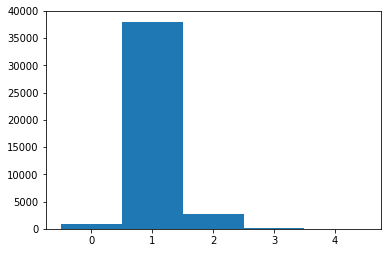

In [22]:
bins, _, _ = plt.hist(nr_nu_like, bins=5, range=(-0.5,4.5))
print("Number of events that are singal:",sum(bins))
print("Number of events that are singal (weighted) :",round(sum(signal_all)))
print("\n")
print("Exactly one candidate with neutrino fragments:", round(sum(good_del+good_only+good_bad+good_match+good_nocharge)))
print(round(sum(good_del)), "\t There was one good candidate but it failed precuts")   
print(round(sum(good_only)), "\t There was one good candidate and it was only one after precuts")   
print(round(sum(good_bad)), "\t There was one good candidate but not the best flashmatch")   
print(round(sum(good_match)), "\t There was one good candidate and the best flashmatch")  
print(round(sum(mixed_pand)), "\t The was no good candidate but one mixed one ") 
print(round(sum(good_nocharge)), "\t The was one good/mixed candidate but it had no collection charge") 
print("\n")
print(round(sum(bad_pand)),"\t There was no candidate with neutrino fragments")
print(round(sum(multi_pand)), "\t There were 2 candidates with neutrino fragments")

#Sanity check that all the categories are independent and sum to 1.
round(sum(bad_pand+multi_pand+good_del+good_only+good_bad+good_match+mixed_pand+good_nocharge))
print(874/21412)
print(943/(8163+943))
print(8163/(8163+943))
print((8163+943)/21412)

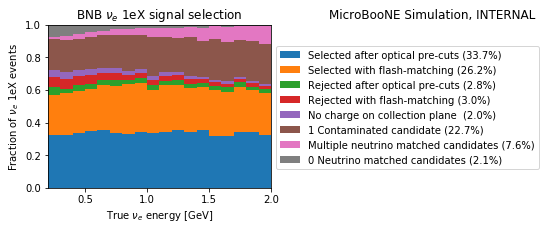

In [23]:
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(4,3))
x_min=0.2
x_max=2
N=18
bhalf = (x_max-x_min)/(2*N)

Energies = [good_only_E, good_match_E, good_del_E, good_bad_E, good_nocharge_E, mixed_pand_E, multi_pand_E, bad_pand_E]
Weights = [good_only, good_match, good_del, good_bad, good_nocharge, mixed_pand, multi_pand, bad_pand]
Labels = ["Selected after optical pre-cuts", "Selected with flash-matching", 
          "Rejected after optical pre-cuts", "Rejected with flash-matching",
          "No charge on collection plane ", "1 Contaminated candidate",
          "Multiple neutrino matched candidates", "0 Neutrino matched candidates"]

lower=np.zeros(N)
signal_all_bins, edges = np.histogram(signal_all_E, weights=signal_all, bins=N, range=(x_min,x_max))
for E,w,lab in zip(Energies, Weights, Labels):
    bins, _ = np.histogram(E, weights=w, bins=edges)
    fraction = sum(w)*100/sum(signal_all)
    bins/=signal_all_bins
    ax.bar(edges[:-1]+bhalf,bins, bottom=lower, label=lab+" ("+'{0:.1f}'.format(fraction)+"%)",width=2*bhalf)
    lower+=bins

ax.set_xlim(x_min,x_max)
ax.set_ylim(0,1)
ax.set_xlabel(r"True $\nu_e$ energy [GeV]")
ax.set_ylabel(r"Fraction of $\nu_e$ 1eX events")
ax.legend(bbox_to_anchor=(1, 0.9))
ax.set_title(r"BNB $\nu_e$ 1eX signal selection")

plt.figtext(1.1,.91,r"MicroBooNE Simulation, INTERNAL",size='large')

plt.savefig(outdir+"optical_selection_energy.pdf", bbox_inches='tight')

20679


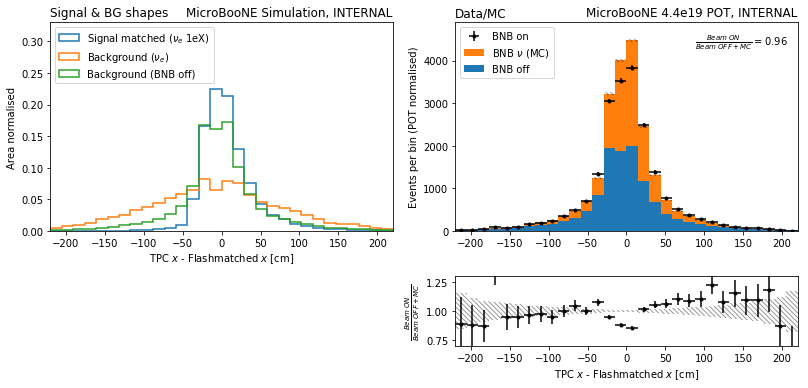

In [24]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5.5), gridspec_kw = {'height_ratios':[3, 1]})
y_r_min=0.7
y_r_max=1.3


x_min = -220
x_max = 220
N=30
bhalf = (x_max-x_min)/(2*N)

ax[0][0].hist(diff_x_good,bins=N, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weights_good)/sum(weights_good), label = r"Signal matched ($\nu_e$ 1eX)", lw=1.5)
ax[0][0].hist(diff_x_bad, bins=N, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weights_bad)/sum(weights_bad), label = r"Background ($\nu_e$)", lw=1.5)

ax[0][0].hist(diff_x_arr[3], bins=N, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weight_arr[3])/sum(weight_arr[3]), label = r"Background (BNB off)", lw=1.5)

ax[0][0].set_title(r"Signal & BG shapes", loc='left')
ax[0][0].set_title(r"MicroBooNE Simulation, INTERNAL", loc='right')
ax[0][0].legend(loc="upper left")
ax[0][0].set_xlabel(r"TPC $x$ - Flashmatched $x$ [cm]")
ax[0][0].set_ylabel("Area normalised")
ax[0][0].set_ylim(0,0.33)
ax[0][0].set_xlim(x_min,x_max)
fig.delaxes(ax[1][0])

y_max=4900
bins,edges = np.histogram(diff_x_arr[2],bins=N, range=(x_min,x_max))
ax[0][1].errorbar(edges[:-1]+bhalf, bins, xerr=bhalf, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax[0][1].hist(diff_x_arr[3],alpha=1.0,bins=N, range=(x_min,x_max), weights = np.ones(len(diff_score_arr[3]))*ext_scale, label = "BNB off" )
mc_bins,_,_ = ax[0][1].hist(diff_x_arr[0],alpha=1.0,bins=edges, weights = np.array(weight_arr[0])*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower

ax[0][1].set_title(r"Data/MC", loc='left')
ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')
ax[0][1].set_xlim(x_min,x_max)
ax[0][1].set_ylim(0,y_max)
ax[0][1].set_ylabel("Events per bin (POT normalised)")
ax[1][1].set_xlabel(r"TPC $x$ - Flashmatched $x$ [cm]")
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc="upper left")

ratio = len(diff_x_arr[2]) / (sum(weight_arr[0])*nu_scale + len(diff_score_arr[3])*ext_scale )
ax[0][1].text(edges[round(N*ratio_x)],ratio_y*y_max,ratio_text+'{0:.2f}'.format(ratio))

# Ratio plots
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_ylim(y_r_min,y_r_max)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges[:-1]+bhalf, bins/mc_bins, xerr=bhalf, yerr=np.sqrt(bins)/mc_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")

mc_err_weighted = hist_bin_uncertainty(list(diff_x_arr[0]),np.array(weight_arr[0]), edges)

mc_ext_err = np.sqrt(  (np.array(mc_err_weighted)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)

for this_err,entry,bin_start,bin_end in zip(mc_ext_err,mc_bins,edges[:-1],edges[1:]):
    ax[0][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bin_end-bin_start, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    
fig.tight_layout()

print(len(diff_score_arr[2]))
plt.savefig( outdir+"flashmatch_x.pdf")

In [25]:
print(len(weight_arr[3]))
print(len(hypo_PE_max_arr[3]))
print(len(diff_x_arr[3]))

26208
26208
26208


20679


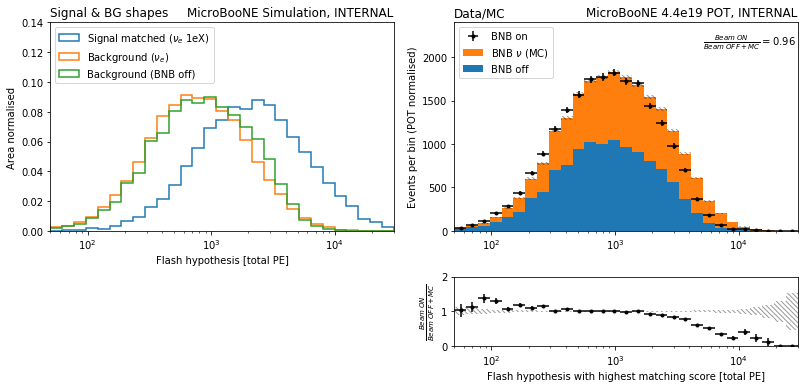

In [26]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5.5), gridspec_kw = {'height_ratios':[3, 1]})
y_r_min=0
y_r_max=2

x_min = 50
x_max = 30000
N=30
bhalf = (x_max-x_min)/(2*N)
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)

x_err= [(edges[i+1]-edges[i])/2 for i in range(N-1)]
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]

ax[0][0].set_xscale("log", nonposx='clip')
ax[0][0].hist(hypo_PE_max_good,bins=edges, histtype="step", range=(x_min,x_max),
           stacked=False, fill=False, weights=np.array(weights_good)/sum(weights_good), label = r"Signal matched ($\nu_e$ 1eX)", lw=1.5)
ax[0][0].hist(hypo_PE_max_bad, bins=edges, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weights_bad)/sum(weights_bad), label = r"Background ($\nu_e$)", lw=1.5)

ax[0][0].hist(hypo_PE_max_arr[3], bins=edges, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weight_arr[3])/sum(weight_arr[3]), label = r"Background (BNB off)", lw=1.5)

ax[0][0].set_title(r"Signal & BG shapes", loc="left")
ax[0][0].set_title(r"MicroBooNE Simulation, INTERNAL", loc='right')
ax[0][0].legend(loc="upper left")
ax[0][0].set_xlabel(r"Flash hypothesis [total PE]")
ax[0][0].set_ylabel("Area normalised")
ax[0][0].set_ylim(0,0.14)
ax[0][0].set_xlim(x_min,x_max)
fig.delaxes(ax[1][0])

ax[0][1].set_xscale("log", nonposx='clip')
bins,edges = np.histogram(hypo_PE_max_arr[2],bins=edges, range=(x_min,x_max))
ax[0][1].errorbar(edges_mid, bins, xerr=x_err, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax[0][1].hist(hypo_PE_max_arr[3],alpha=1.0,bins=edges, range=(x_min,x_max), weights = np.ones(len(hypo_PE_max_arr[3]))*ext_scale, label = "BNB off" )
mc_bins,_,_ = ax[0][1].hist(hypo_PE_max_arr[0],alpha=1.0,bins=edges, weights = np.array(weight_arr[0])*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower
ax[0][1].set_title(r"Data/MC", loc="left")
ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')

ax[0][1].set_xlim(x_min,x_max)
y_max= 2400
ax[0][1].set_ylim(0, y_max)
ax[0][1].set_ylabel("Events per bin (POT normalised)")
ax[1][1].set_xlabel(r"Flash hypothesis with highest matching score [total PE]")
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc="upper left")
ratio = len(diff_x_arr[2]) /  (sum(weight_arr[0])*nu_scale + len(diff_score_arr[3])*ext_scale )
ax[0][1].text(edges[round(N*ratio_x)],ratio_y*y_max,ratio_text+'{0:.2f}'.format(ratio))

# Ratio plots
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_ylim(y_r_min,y_r_max)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges_mid, bins/mc_bins, xerr=x_err, yerr=np.sqrt(bins)/mc_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")
ax[1][1].set_xscale("log", nonposx='clip')

mc_err_weighted = hist_bin_uncertainty(list(hypo_PE_max_arr[0]),np.array(weight_arr[0]), edges)

mc_ext_err = np.sqrt(  (np.array(mc_err_weighted)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)

for this_err,entry,bin_start,bin_end in zip(mc_ext_err,mc_bins,edges[:-1],edges[1:]):
    ax[0][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bin_end-bin_start, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    

fig.tight_layout()

print(len(diff_score_arr[2]))
plt.savefig( outdir+"flashmatch_hypo_PE.pdf")

20679


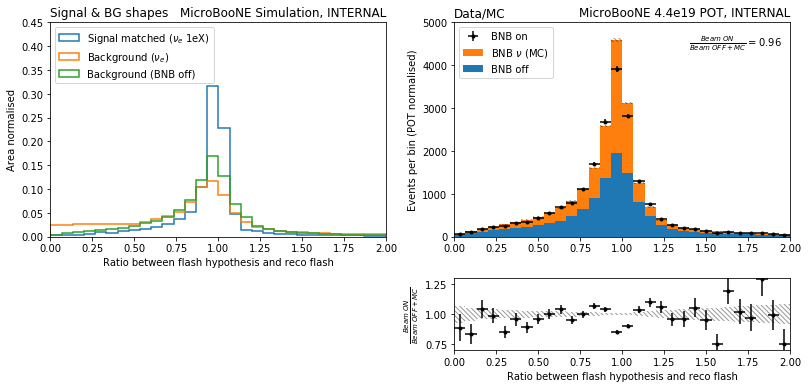

In [27]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5.5), gridspec_kw = {'height_ratios':[3, 1]})
y_r_min=0.7
y_r_max=1.3

x_max=2
x_min=0
N=30
bhalf = (x_max-x_min)/(2*N)


ax[0][0].hist(ratio_hypo_PE_good,bins=N, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weights_good)/sum(weights_good), label = r"Signal matched ($\nu_e$ 1eX)", lw=1.5)
ax[0][0].hist(ratio_hypo_PE_bad, bins=N, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weights_bad)/sum(weights_bad), label = r"Background ($\nu_e$)", lw=1.5)

ax[0][0].hist(ratio_hypo_PE_arr[3], bins=N, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weight_arr[3])/sum(weight_arr[3]), label = r"Background (BNB off)", lw=1.5)

ax[0][0].set_title(r"Signal & BG shapes", loc='left')
ax[0][0].set_title(r"MicroBooNE Simulation, INTERNAL", loc='right')
ax[0][0].legend(loc="upper left")
ax[0][0].set_xlabel(r"Ratio between flash hypothesis and reco flash")
ax[0][0].set_ylabel("Area normalised")
ax[0][0].set_ylim(0,0.45)
ax[0][0].set_xlim(x_min,x_max)
fig.delaxes(ax[1][0])

bins,edges = np.histogram(ratio_hypo_PE_arr[2],bins=N, range=(x_min,x_max))
ax[0][1].errorbar(edges[:-1]+bhalf, bins, xerr=bhalf, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax[0][1].hist(ratio_hypo_PE_arr[3],alpha=1.0,bins=N, range=(x_min,x_max), weights = np.ones(len(ratio_hypo_PE_arr[3]))*ext_scale, label = "BNB off" )
mc_bins,_,_ = ax[0][1].hist(ratio_hypo_PE_arr[0],alpha=1.0,bins=edges, weights = np.array(weight_arr[0])*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower
ax[0][1].set_title(r"Data/MC", loc='left')
ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')

ax[0][1].set_xlim(x_min,x_max)
y_max = 5000
ax[0][1].set_ylim(0,y_max)
ax[0][1].set_ylabel("Events per bin (POT normalised)")
ax[1][1].set_xlabel(r"Ratio between flash hypothesis and reco flash")
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc="upper left")
ratio = len(ratio_hypo_PE_arr[2]) /  (sum(weight_arr[0])*nu_scale + len(ratio_hypo_PE_arr[3])*ext_scale )
ax[0][1].text(edges[round(N*ratio_x)],ratio_y*y_max,ratio_text+'{0:.2f}'.format(ratio))

# Ratio plots
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_ylim(y_r_min,y_r_max)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges[:-1]+bhalf, bins/mc_bins, xerr=bhalf, yerr=np.sqrt(bins)/mc_bins ,alpha=1.0, color= "k",fmt=".",label="Data error")

mc_err_weighted = hist_bin_uncertainty(list(ratio_hypo_PE_arr[0]),np.array(weight_arr[0]), edges)

mc_ext_err = np.sqrt(  (np.array(mc_err_weighted)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)

for this_err,entry,bin_start,bin_end in zip(mc_ext_err,mc_bins,edges[:-1],edges[1:]):
    ax[0][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    sc_err = this_err/entry
    ax[1][1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bin_end-bin_start, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    
    
fig.tight_layout()

print(len(diff_score_arr[2]))
plt.savefig( outdir+"flashmatch_hypo_PE_ratio.pdf")

[1.0000000e-05 7.5009500e-02 1.5000900e-01 2.2500850e-01 3.0000800e-01
 3.7500750e-01 4.5000700e-01 5.2500650e-01 6.0000600e-01 6.7500550e-01
 7.5000500e-01 8.2500450e-01 9.0000400e-01 9.7500350e-01 1.0500030e+00
 1.1250025e+00 1.2000020e+00 1.2750015e+00 1.3500010e+00 1.4250005e+00
 1.5000000e+00]


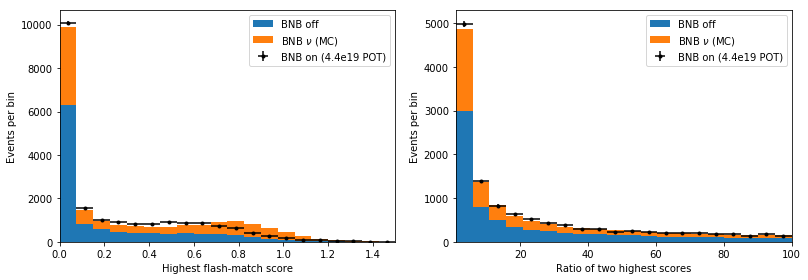

In [28]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(7*gr,4),sharex=False)
x_min = 10e-6
x_max = 1.5
N=20
bhalf = (x_max-x_min)/(2*N)


bins,edges = np.histogram(score_max_arr[2],bins=N, range=(x_min,x_max))
ax[0].errorbar(edges[:-1]+bhalf, bins, xerr=bhalf, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on (4.4e19 POT)")
lower,_,_ = ax[0].hist(score_max_arr[3],alpha=1.0,bins=N, range=(x_min,x_max), weights = np.ones(len(score_max_arr[3]))*ext_scale, label = "BNB off" )

print(edges)
ax[0].hist(score_max_arr[0],alpha=1.0,bins=edges, range=(x_min,x_max), weights = np.array(weight_arr[0])*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(0.1500)
ax[0].set_ylabel("Events per bin")
ax[0].set_xlabel("Highest flash-match score")
ax[0].legend(loc="upper right")

x_min = 1
x_max = 1e2
N=20
bhalf = (x_max-x_min)/(2*N)

bins,edges = np.histogram(diff_score_arr[2],bins=N, range=(x_min,x_max))
ax[1].errorbar(edges[:-1]+bhalf, bins, xerr=bhalf, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on (4.4e19 POT)")
lower,_,_ = ax[1].hist(diff_score_arr[3],alpha=1.0,bins=N, range=(x_min,x_max), weights = np.ones(len(diff_score_arr[3]))*ext_scale, label = "BNB off" )
ax[1].hist(diff_score_arr[0],alpha=1.0,bins=edges, range=(x_min,x_max), weights = np.array(weight_arr[0])*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )

ax[1].set_xlim(x_min,x_max)
ax[1].set_ylim(0.1500)
ax[1].set_ylabel("Events per bin")
ax[1].set_xlabel("Ratio of two highest scores")
ax[1].legend(loc="upper right")

fig.tight_layout()

plt.savefig( outdir+"flashmatch.pdf")

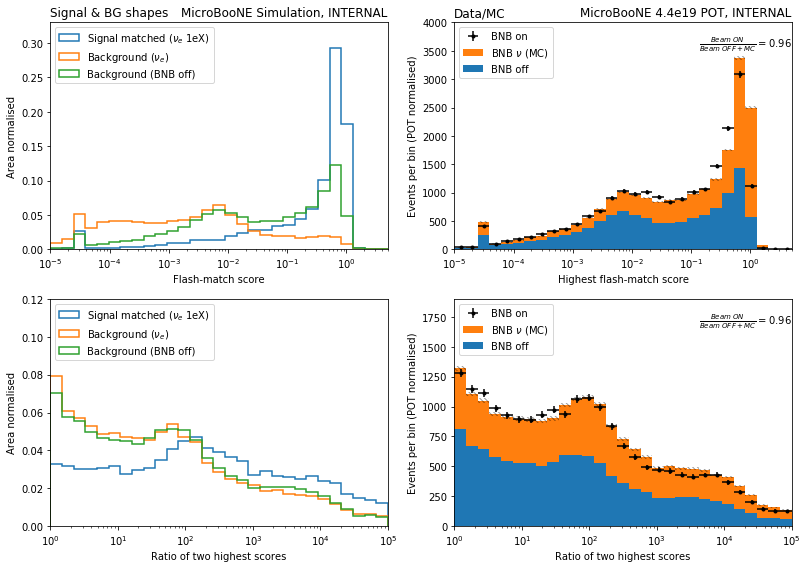

In [29]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,8),sharex=False)
x_min = 10e-6
x_max = 5.0
N=30
y_max=4000
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
x_err= [(edges[i+1]-edges[i])/2 for i in range(N-1)]
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]

ax[0][0].set_xscale("log", nonposx='clip')
ax[0][0].hist(score_max_good,bins=edges, histtype="step", range=(x_min,x_max),
           stacked=False, fill=False, weights=np.array(weights_good)/sum(weights_good), label = r"Signal matched ($\nu_e$ 1eX)", lw=1.5)
ax[0][0].hist(score_max_bad, bins=edges, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weights_bad)/sum(weights_bad), label = r"Background ($\nu_e$)", lw=1.5)

ax[0][0].hist(score_max_arr[3], bins=edges, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weight_arr[3])/sum(weight_arr[3]), label = r"Background (BNB off)", lw=1.5)

ax[0][0].set_title(r"Signal & BG shapes", loc='left')
ax[0][0].set_title(r"MicroBooNE Simulation, INTERNAL", loc='right')
ax[0][0].legend(loc="upper left")
ax[0][0].set_xlabel(r"Flash-match score")
ax[0][0].set_ylabel("Area normalised")
ax[0][0].set_ylim(0,0.33)
ax[0][0].set_xlim(x_min,x_max)


bins,_ = np.histogram(score_max_arr[2],bins=edges,range=(x_min,x_max))
ax[0][1].errorbar(edges_mid, bins, xerr=x_err, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax[0][1].hist(score_max_arr[3],alpha=1.0,bins=edges, range=(x_min,x_max), weights = np.ones(len(score_max_arr[3]))*ext_scale, label = "BNB off" )
mc_bins,_,_ = ax[0][1].hist(score_max_arr[0],alpha=1.0,bins=edges, range=(x_min,x_max), weights = np.array(weight_arr[0])*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower
ax[0][1].set_title(r"Data/MC", loc='left')
ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, INTERNAL", loc='right')
ax[0][1].set_xscale("log", nonposx='clip')
ax[0][1].set_xlim(x_min,x_max)
ax[0][1].set_ylim(0,y_max)
ax[0][1].set_ylabel("Events per bin (POT normalised)")
ax[0][1].set_xlabel("Highest flash-match score")
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend(handles[::-1], labels[::-1],loc="upper left")

mc_err_weighted = hist_bin_uncertainty(list(score_max_arr[0]),np.array(weight_arr[0]), edges)
mc_ext_err = np.sqrt(  (np.array(mc_err_weighted)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)

for this_err,entry,bin_start,bin_end in zip(mc_ext_err,mc_bins,edges[:-1],edges[1:]):
    ax[0][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    
ratio = len(ratio_hypo_PE_arr[2]) /  (sum(weight_arr[0])*nu_scale + len(ratio_hypo_PE_arr[3])*ext_scale )
ax[0][1].text(edges[round(N*ratio_x)],ratio_y*y_max,ratio_text+'{0:.2f}'.format(ratio))

x_min = 1
x_max = 1e5
N=30
y_max=1900
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
x_err= [(edges[i+1]-edges[i])/2 for i in range(N-1)]
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]


ax[1][0].set_xscale("log", nonposx='clip')
ax[1][0].hist(diff_score_good,bins=edges, histtype="step", range=(x_min,x_max),
           stacked=False, fill=False, weights=np.array(weights_good)/sum(weights_good), label = r"Signal matched ($\nu_e$ 1eX)", lw=1.5)
ax[1][0].hist(diff_score_bad, bins=edges, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weights_bad)/sum(weights_bad), label = r"Background ($\nu_e$)", lw=1.5)

ax[1][0].hist(diff_score_arr[3], bins=edges, range=(x_min,x_max), histtype="step", 
           stacked=False, fill=False, weights=np.array(weight_arr[3])/sum(weight_arr[3]), label = r"Background (BNB off)", lw=1.5)

#ax[1][0].set_title(r"Signal and background distributions")
ax[1][0].legend(loc="upper left")
ax[1][0].set_xlabel(r"Ratio of two highest scores")
ax[1][0].set_ylabel("Area normalised")
ax[1][0].set_ylim(0,0.12)
ax[1][0].set_xlim(x_min,x_max)


bins,edges = np.histogram(diff_score_arr[2],bins=edges, range=(x_min,x_max))
ax[1][1].errorbar(edges_mid, bins, xerr=x_err, yerr=np.sqrt(bins),alpha=1.0, color= "k",fmt=".",label="BNB on")
lower,_,_ = ax[1][1].hist(diff_score_arr[3],alpha=1.0,bins=edges, range=(x_min,x_max), weights = np.ones(len(diff_score_arr[3]))*ext_scale, label = "BNB off" )
mc_bins,_,_ = ax[1][1].hist(diff_score_arr[0],alpha=1.0,bins=edges, range=(x_min,x_max), weights = np.array(weight_arr[0])*nu_scale, label=r"BNB $\nu$ (MC)",  bottom = lower )
mc_bins+=lower

ax[1][1].set_xscale("log", nonposx='clip')
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].set_ylim(0,y_max)
ax[1][1].set_ylabel("Events per bin (POT normalised)")
ax[1][1].set_xlabel("Ratio of two highest scores")
handles, labels = ax[1][1].get_legend_handles_labels()
ax[1][1].legend(handles[::-1], labels[::-1],loc="upper left")
ratio = len(ratio_hypo_PE_arr[2]) /  (sum(weight_arr[0])*nu_scale + len(ratio_hypo_PE_arr[3])*ext_scale )
ax[1][1].text(edges[round(N*ratio_x)],ratio_y*y_max,ratio_text+'{0:.2f}'.format(ratio))

mc_err_weighted = hist_bin_uncertainty(list(diff_score_arr[0]),np.array(weight_arr[0]), edges)
mc_ext_err = np.sqrt(  (np.array(mc_err_weighted)*nu_scale)**2 + (np.sqrt(lower/ext_scale)*ext_scale)**2)

for this_err,entry,bin_start,bin_end in zip(mc_ext_err,mc_bins,edges[:-1],edges[1:]):
    ax[1][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
    
    
fig.tight_layout()

plt.savefig( outdir+"flashmatch_log.pdf")

In [30]:
# What is selected by the optical simulation?

total_all= []
total_selected = []
good_one = []
mixed_one = []
good_multi = []
mixed_multi = []
cosmic = []
not_sel = []

df=df_nue.query("true_1eX_signal==1 & true_z_deadwire==1")
for index, row in df.iterrows():
    ww = row["bnbweight"]
    total_all.append(ww)
    # We want events passing the optical selection
    fl_passed = row["flash_passed"]>-1
    if np.any(fl_passed):
        passed_index = np.argmax(fl_passed)
        total_selected.append(ww)
        
        ob_pr = row["number_primary_tracks"] + row["number_primary_showers"]
        ob_nu = row["track_passed"] + row["shower_passed"]
        ob_nu_all = sum(ob_nu)
        ob_pr_this = ob_pr[passed_index]
        ob_nu_this = ob_nu[passed_index]
        
        # Good candidate, only one
        if ob_pr_this==ob_nu_this:
            if ob_nu_all==ob_nu_this:
                good_one.append(ww)
            else:
                good_multi.append(ww)
        elif ob_nu_this>0:
            if ob_nu_all==ob_nu_this:
                mixed_one.append(ww)
            else:
                mixed_multi.append(ww)
        else:
            cosmic.append(ww)
    else:
        not_sel.append(ww) 

In [31]:
data = [good_one, mixed_one, good_multi+mixed_multi, cosmic, not_sel]
categories = (r'$\nu_e$ reco-truth matched',r"$\nu_e$ contaminated", r'$\nu_e$ fragment', 'Cosmic', "Not selected")

print("Total selection percentage: ", '{0:.1f}'.format(sum(total_selected)*100/sum(total_all)))
sum_data = []
percentages = []
labels= []
for dat,lab in zip(data,categories):
    sum_data.append(sum(dat))
    print('{0:.0f}'.format(sum_data[-1])+"\t"+lab)
    percentages.append(sum(dat)/sum(total_all)*100)
    print('{0:.1f}'.format(percentages[-1])+"% of selected")
    labels.append(lab+" ("+'{0:.1f}'.format(percentages[-1])+"%)")
    print("\n")


Total selection percentage:  94.5
19047	$\nu_e$ reco-truth matched
59.9% of selected


6479	$\nu_e$ contaminated
20.4% of selected


2104	$\nu_e$ fragment
6.6% of selected


2429	Cosmic
7.6% of selected


1764	Not selected
5.5% of selected




[19046.91225746874, 6478.514851208097, 2104.0496022703446, 2428.506907494976, 1763.536862858483]


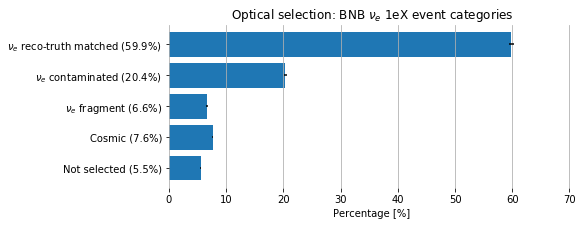

In [32]:
fig, ax = plt.subplots(figsize=(4.5*gr,3))

y_pos = np.arange(len(categories))
print(sum_data)
error = np.sqrt(np.array(sum_data))/sum(total_all)*100
ax.barh(y_pos, percentages, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percentage [%]')
ax.set_title(r'Optical selection: BNB $\nu_e$ 1eX event categories')
ax.xaxis.grid()
ax.set_xlim(0,71)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#fig.tight_layout()
plt.savefig( outdir+"opt_selected.pdf",bbox_inches='tight')